#### Sloan Digital Sky Survey (SDSS)
##### SDSS: Background
- The Sloan Digital Sky Survey is an ongoing astronomical survey, that gathers data on celestial objects in the universe.
- It uses a dedicated 2.5m telescope located due south of Cloudcroft, NM in the Sacramento Mountains.
- The telescope uses different bandbass filters (u,g,r,i,z) to observe stars, quasars, galaxies, and other celestial bodies at different wavelengths (354nm,476nm,628nm,769nm,925nm).
##### SDSS: Motivation
- During my undergraduate studies, I gained foundational experience in astronomical research by conducting photometric studies of variable stars. Building upon this, my post-baccalaureate research shifted to the dynamic interaction between solar storms and Earth's magnetosphere. Now, as a software developer within the space research group at Los Alamos National Lab, I continue to engage with space-related data. I aimed to identify a publicly available dataset that harmonizes with my professional experience and personal research interests. Naturally, the Sloan Digital Sky Survey (SDSS) emerged as the optimal resource while scouring the world wide web for a suitable dataset.

#### Data Access
1. clone git repo
    - via ssh: `git clone git@github.com:0tv0renakniga/207_final_project.git`
    - via https: `https://github.com/0tv0renakniga/207_final_project.git`
2. setup venv and activate
3. use resources/requirements.txt to install all libraries needed
4. see environment.md for help

#### Preliminary Data Exploration
##### Data Exploration: Analysis Steps
1. Import python libraries
2. Read sdss_data.csv as a pandas dataframe
3. Check the quality of the dataset: number of observations, null values, and existing outliers.
4. Clean dataset: remove/rename null values, remove erroneous observations, and unfruitful features.
5. Visualize distribution for numerical, categorical, and spatial variables

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units, constants
import sklearn
import warnings

# ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
# read in csv DR 18 from sdss
df = pd.read_csv('sdss_data.csv')

In [4]:
# quality check look at size, first five rows, stats, and info
def check_quality(dataframe):
    print(f'SIZE:\n number of rows: {dataframe.shape[0]}\n number of cols:{dataframe.shape[1]}\n')
    print(f'INFO:\n {dataframe.info()}\n')
    print(f'COL STATS:\n {df.describe()}')

check_quality(df)

SIZE:
 number of rows: 5555
 number of cols:19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         5555 non-null   float64
 1   g         5555 non-null   float64
 2   r         5555 non-null   float64
 3   i         5555 non-null   float64
 4   z         5555 non-null   float64
 5   u-g       5555 non-null   float64
 6   g-r       5555 non-null   float64
 7   r-i       5555 non-null   float64
 8   i-z       5555 non-null   float64
 9   class     5555 non-null   object 
 10  subClass  5299 non-null   object 
 11  redshift  5555 non-null   float64
 12  mjd       5555 non-null   int64  
 13  clean     5555 non-null   int64  
 14  mode      5555 non-null   int64  
 15  zWarning  5555 non-null   int64  
 16  probPSF   5555 non-null   int64  
 17  ra        5555 non-null   float64
 18  dec       5555 non-null   float64
dtypes: float64(12), int64

In [5]:
# fill null values for QSO and GALAXY subclasses
df['subClass']= np.where((df['class']=='QSO') & (df['subClass'].isnull()),'Mystery QSO',df['subClass'])
df['subClass']= np.where((df['class']=='GALAXY') & (df['subClass'].isnull()),'Mystery GALAXY',df['subClass'])

In [6]:
'''
check how many observations exist where bandpass filters(u,g,i,z) equal to -9999.0 
look at how this changes the statistics 
get new shape of the dataframe
'''
# check how many observations are moving the min down for all bandpass filters
print(df[(df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0)])
print(df[~((df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0))].describe())
print(df[~((df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0))].shape)

          u       g         r       i       z  u-g       g-r       r-i  i-z  \
988 -9999.0 -9999.0  17.11245 -9999.0 -9999.0  0.0 -10016.11  10016.11  0.0   

    class subClass  redshift    mjd  clean  mode  zWarning  probPSF  \
988  STAR       G2  0.000885  51994      1     1         0        1   

            ra       dec  
988  213.66598  1.053796  
                 u            g            r            i            z  \
count  5554.000000  5554.000000  5554.000000  5554.000000  5554.000000   
mean     20.674796    19.766779    19.367600    19.175532    19.065653   
std       1.569617     1.531219     1.561967     1.623607     1.687704   
min      14.776010    13.692100    13.420710    13.334080    13.339550   
25%      19.711423    18.882180    18.459125    18.178117    18.023465   
50%      20.863510    20.159115    19.761040    19.553970    19.399420   
75%      21.642585    20.965988    20.532680    20.357185    20.175042   
max      25.850370    26.280410    23.024370    23.0

In [7]:
# only 1 observation where u,g,r, or z is -9999.0 so we will drop it
df = df[~((df['u']==-9999.0) | (df['g']==-9999.0) | (df['i']==-9999.0) | (df['z']==-9999.0))]
'''
the columns following columns are binary classifiers that measure quality: clean, mode, zWarning, probPSF 
since they are all true(value=1) this does not give us any additional information
therefore we will drop clean, mode, zWarning, probPSF columns from our data frame
'''
df.drop(['clean', 'mode','zWarning','probPSF'],axis=1,inplace=True)

##### Data Exploration: Quality Comments
- `sdss_data.csv` contains 5,555 rows and 19 columns
- Null values existed in the `'subClass'` column which corresponded to quasars and galaxies without a subclass type. Null values for these cases were renamed to Mystery QSO and Mystery GALAXY
- Removed columns that represented binary classifiers where all observations were true
- Dropped one row where apparent magnitude was -9999.0
    - The sun only has an apparent magnitude of -26.8, so it is safe to assume this is just a bad observation.


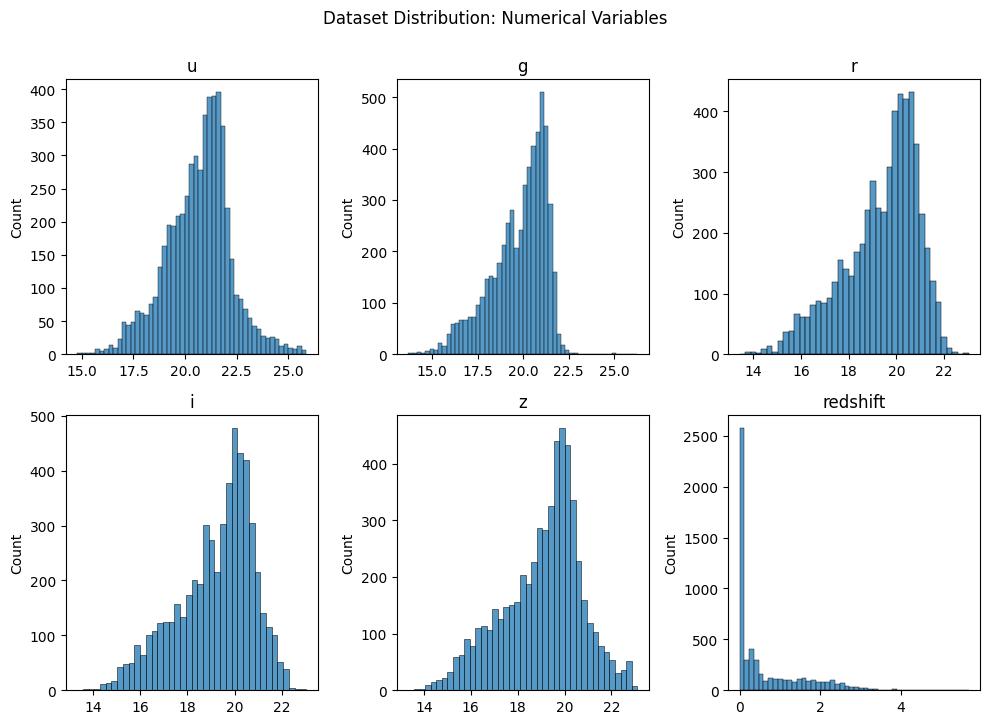

In [8]:
'''
only lost 1 observations where the bandpass filters are equal to -9999.0
looking at means and modes for each feature of our dataset they appear very close
see note above***
use df.sample(n=sample_size, random_state=1) and add sample size to funtion
=================================================================================
let's look at a histogram for the following numerical features:
bandpass filters(u,g,r,i,z)
redshift

not interested in looking at right ascension or declination since this is just a position
on the celestial sphere.. think how we use latitude and longitude on earth

not interested in looking at distribution of class or subClass since these are 
categorical variables

mjd(modified julian date) can be both categorical or numeric depending on our analysis.
dig into this later..
'''

# create a list of numerical variables
num_vars = ['u', 'g', 'r', 'i', 'z','redshift']
def num_vars_dist(df,num_vars,nplots_rows,nplots_cols):
    '''
    Input
    df: pd.dataframe -> pandas DataFrame containing data
    num_var: list -> list of column names found in the dataframe
    nplots_rows: int -> total rows for subplots
    nplots_cols: int -> total columns for subplots
    '''
    fig, ax = plt.subplots(nplots_rows,nplots_cols,figsize=(10, 8))
    fig.suptitle("Dataset Distribution: Numerical Variables",y=0.9)
    ax = ax.flatten()
    
    for i, num_var in enumerate(num_vars):
        sns.histplot(df[num_var],ax=ax[i]) 
        ax[i].set_title(num_var)
        ax[i].set_xlabel('')
    
    fig.tight_layout(rect=[0,0,1,0.9])
    plt.show()

# create figure to visualize distribution for numerical variables
num_vars_dist(df,num_vars,2,3)

##### Data Exploration: Numerical Variable Distribution Comments
- The bandpass filter u is least skewed compared to other numerical variables as it appears to be normally distributed.
- The feature redshift is the most skewed with the majority of it's points hovering just above 0.

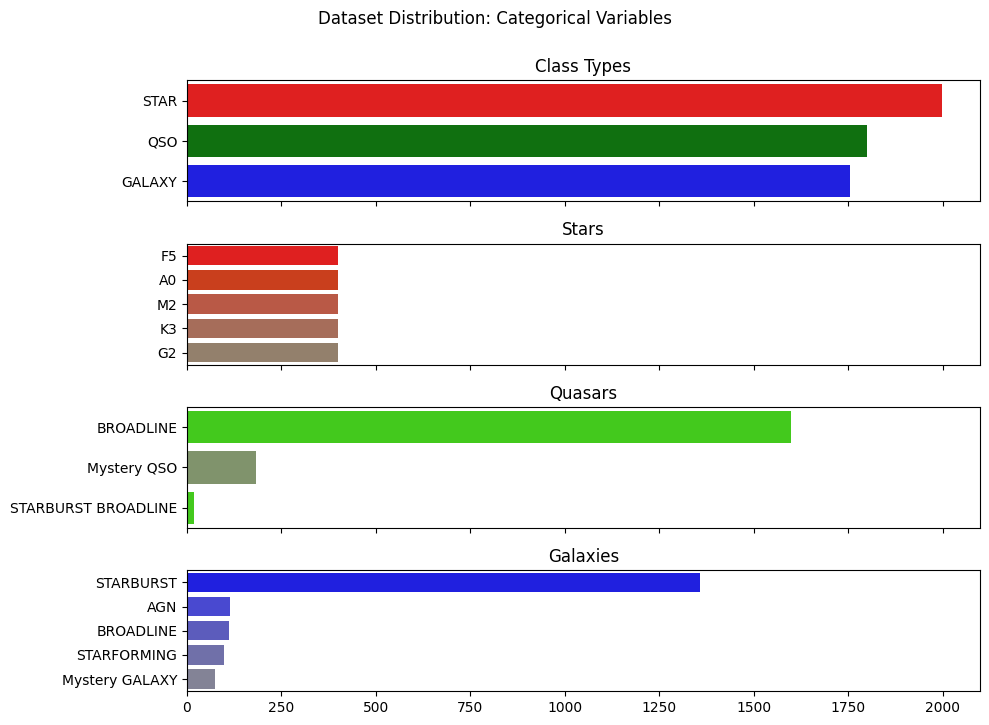

In [9]:

'''
let's look at a bar plots for the following categorical features:
class
subClass
'''
# create a list of numerical variables
cat_vars = ['class','subClass']
def num_vars_dist(df,cat_vars,nplots_rows,nplots_cols):
    '''
    Input
    df: pd.dataframe -> pandas DataFrame containing data
    num_var: list -> list of column names found in the dataframe
    nplots_rows: int -> total rows for subplots
    nplots_cols: int -> total columns for subplots
    '''
    fig, ax = plt.subplots(nplots_rows,nplots_cols,figsize=(10, 8),sharex=True)
    fig.suptitle("Dataset Distribution: Categorical Variables",y=0.9)
    ax = ax.flatten()
    
    # colors for subplots
    class_colors = {'STAR': 'red', 'QSO': 'green', 'GALAXY': 'blue'}
    star_colors = ["#FF0000", "#E62E00", "#CC4C33", "#B3664D", "#998066"]
    quasar_colors = ['#33E600','#809966']
    galaxy_colors = ["#0000FF","#3333E6", "#4C4CCC",  "#6666B3", "#808099"]
    all_colors = [class_colors,star_colors,quasar_colors,galaxy_colors]

    #titles for subplots
    all_titles = ['Class Types','Stars','Quasars','Galaxies']

    #list of subplots
    plots = [(df['class'].value_counts().values,df['class'].value_counts().index),
             (df[df['class']=='STAR']['subClass'].value_counts().values,df[df['class']=='STAR']['subClass'].value_counts().index),
             (df[df['class']=='QSO']['subClass'].value_counts().values,df[df['class']=='QSO']['subClass'].value_counts().index),
             (df[df['class']=='GALAXY']['subClass'].value_counts().values,df[df['class']=='GALAXY']['subClass'].value_counts().index)]

    for i, nplot in enumerate(plots):
        sns.barplot(x=nplot[0], y=nplot[1], ax=ax[i],palette=all_colors[i]) 
        ax[i].set_title(all_titles[i])
        ax[i].set_ylabel('')
    
    fig.tight_layout(rect=[0,0,1,0.9])
    plt.show()
    
# create figure to visualize distribution for categorical variables
num_vars_dist(df,cat_vars,4,1)


##### Data Exploration: Categorical Variable Distribution Comments
- Class types are STAR, QSO(Quasar), and GALAXY
    - Counts: 1999 Stars, 1800 Quasars, and 1755 Galaxies
    - Star subclasses are nearly evenly distributed
        - Counts: 400 F0, 400 A0, 400 M2, 400 K3, and 399 G2
    - Quasar subclasses contain mostly Broad Line Quasars
        - Counts: 1599 Broad Line, 18 Starburst Broad Line, and 183 Mystery
    - Galaxy subclasses are primarily Starburst Galaxies
        - Counts: 1357 Starburst, 115 AGN (Active Galactic Nuclei), 111 Broad Line, 99 Star forming, and 73 Mystery 

In [10]:
# convert modified julian date to standard date
df['date'] = pd.to_datetime(df.mjd, unit='D', origin='1858-11-17')

# check what our years our data spans
print(f'The dataset spans {df.date.dt.year.max()-df.date.dt.year.min()} years from \
{df.date.dt.year.min()} to {df.date.dt.year.max()}')


The dataset spans 20 years from 2000 to 2020


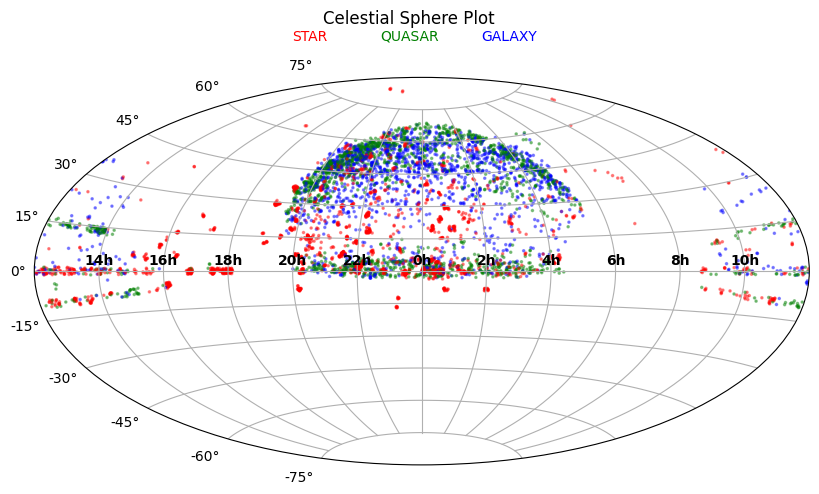

In [11]:
# we know temporal spread of data lets look at spatial distribution

def plot_celestial(ra_deg, dec_deg, obj_class):
    """Plots RA and Dec on an Aitoff projection."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)
    # Convert RA to -180 to 180 range for Aitoff projection 
    # 0 to 360 --> -180 to 180 by subtracting 180
    ra_deg = ra_deg-180

    # Convert RA to radians
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    # Create a dictionary to map classes to colors
    class_colors = {'STAR': 'red', 'QSO': 'green', 'GALAXY': 'blue'}
    colors = [class_colors[c] for c in obj_class]

    ax.scatter(ra_rad, dec_rad, s=10, alpha=0.4, marker='.', color=colors)  # Single color for now

    # set title
    fig.text(0.5, 0.80, "Celestial Sphere Plot", ha="center", va="bottom", size="large")
    fig.text(0.4, 0.78, "STAR", ha="center", va="bottom", size="medium",color="red")
    fig.text(0.5, 0.78, "QUASAR", ha="center", va="bottom", size="medium",color='green')
    fig.text(0.6,0.78,"GALAXY", ha="center", va="bottom", size="medium",color="blue")

    # Set tick labels for RA (optional)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'],fontweight='bold')
    
    plt.show()
plot_celestial(df.ra, df.dec, df['class'])

##### Data Exploration: Spatial Variable Distribution Comments
- The majority of the observations are found between 20h and 4h on the celestial sphere.

## Research Questions

1. Redshift Skewness: Can we apply a transformation to redshift to better understand the drastic skewness seen in the exploratory analysis?

2. Star Clusters: Is photometric data from bandpass filters (u,g,r,i,z) sufficient to cluster the different star spectral classes? Does clustering by color index (B-V) give us stronger clustering?

3. ML Classification: Do classes and subclasses in the sdss dataset have a unique signatures, comprised of numerical variable combinations?

#### Redshift Skewness
*Can we apply a transformation to redshift to better understand the drastic skewness seen in the exploratory analysis?*

##### Redshift Skewness: Background

- Redshift refers to the stretching of electromagnetic energy(increase in wavelength) from a source due to the expansion of the universe.
- Velocity or an object's speed is defined as the distance the objects travels divided by the amount of time it takes the object to traverse said distance.
    - $v = \frac{d}{t}$ (1)
- Light is electromagnetic energy and the speed of light (c) is equal to the product of wavelength and frequency.
    - $c = \lambda \nu $ (2)
- The Doppler Formula shows us that a change in an objects redshift is proportional to its change in velocity. For example, if there is an increase in redshift then the object's velocity must increase as well.
    - $1 + z = \sqrt{\frac{1 + \frac{v}{c}}{1 - \frac{v}{c}}}$ (3)
- We can rearrange the Doppler formula to get an equation for velocity. After a deep equation massage the resulting equation is the following.
    - $v =  c\frac{(1 + z)^2 - 1}{(1 + z)^2 + 1}$ (4)
- Hubble's Law tells us that the recession velocity is proportional to its distance
    - $d = \frac{v}{H_0} $(5)
    - the Hubble constant $H_0$ ~ $70 \frac{km}{s Mpc}$
- By substituting (4) into (5) we have a function that relates distance to redshift. While this works as a good estimate for distance. 
- A parsec is a unit of distance equivalent to $3.26$ light years or $3.086 \times 10^{13} km$.

##### Redshift Skewness: Analysis Steps
1. Calculate velocity for stars, quasars, and galaxies using equation (4)
2. Calculate distance for stars, quasars and galaxies using the Hubble's Law equation (5)
3. Add all distances calculated to `df` in a new column for distance `df['dist']`
4. Plot distance results vs right ascension and interpret results.

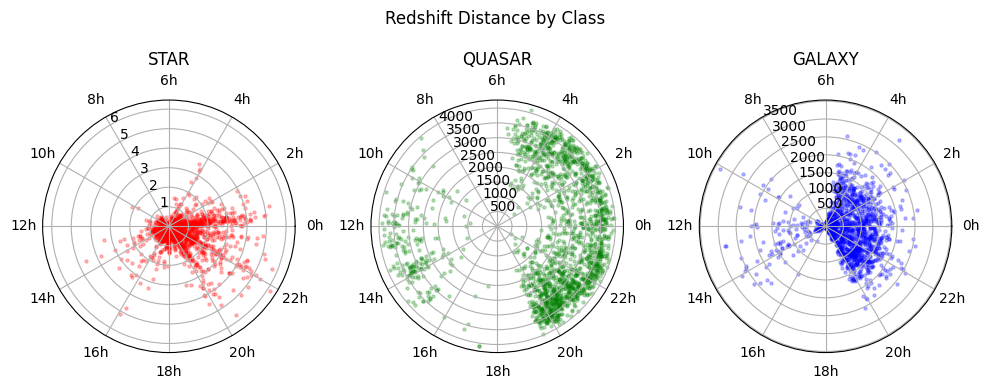

In [12]:
# calc distance from Hubble's Law
def dist_from_hl(df):
    z = df['redshift']
    H0 = 70 * units.km/units.s/units.Mpc
    c = constants.c.to('km/s')
    # solve for velocity
    v = c*(((1 + z)**2 - 1) / ((1 + z)**2 + 1))
    # solve for distance unit Mpc or 1 million parsecs
    d = v/H0
    # convert Mpc to pc
    df['dist'] = d * 1e6
    df_hl =pd.DataFrame()
    df_hl['dist'] = d
    df_hl['ra'] = df['ra']
    df_hl['class'] = df['class']
    return(df_hl)

df_hl = dist_from_hl(df)

# plot results on polar plot
def redshift_dist(df):
    fig, ax = plt.subplots(1,3,figsize=(10, 8),subplot_kw={'projection': 'polar'})
    fig.suptitle("Redshift Distance by Class",y=0.75)
    ax = ax.flatten()
    class_colors = {'STAR': 'red', 'QSO': 'green', 'GALAXY': 'blue'}
    
    for i, obj_type in enumerate(df['class'].unique()):
        dist = df[df['class']==obj_type]['dist']
        ra_deg = df[df['class']==obj_type]['ra']-180
        ra_rad = np.radians(ra_deg)
        ax[i].scatter(ra_rad, dist, s=5, alpha=0.25, color=class_colors[obj_type]) 
        if obj_type == 'QSO':
            ax[i].set_title("QUASAR")
        else:
            ax[i].set_title(f"{obj_type}")
        ax[i].set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))  # Divide into 12
        ax[i].set_xticklabels(['0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'])
        ax[i].set_rlabel_position(120)
        ax[i].grid(True)
    
    fig.tight_layout()
    plt.show()

redshift_dist(df_hl)

##### Redshift Skewness: Interpretation
*Can we apply a transformation to redshift to better understand the drastic skewness seen in the exploratory analysis?*
- From the Redshift Distance by Class we see that the majority of stars are less than 6 Mpc, and roughly a third of the galaxies are less than 500 Mpc. While the rest of our lies between 500 Mpc and 4000 Mpc. The sum of stars and one third of our galaxies is approximately 2500 objects. This is approximately what we see in the Dataset Distribution: Numerical Variables plot.

##### Redshift Skewness: Bias
- Accounting for relativistic effects and applying Hubble's Law was a connivent way to estimate the distance for objects in the SDSS dataset. This convenience comes with a price. As redshift increases it is important to account for other factors like reddening from cosmic dust and dark matter.


#### Star Clusters
* Is photometric data from bandpass filters (u,g,r,i,z)sufficient to cluster the different star spectral classes? Does clustering by color index (B-V) give us stronger clustering?*

##### Star Clusters: Background
- Star spectral classes help differentiate stars based on their color, temperature, and spectral characteristics. The spectral classes are O, B, A, F, G, K, M. Stars belonging to the O class are blue in color and have a very high temperature. While type M stars are cool and are more red in color.
- The Dataset Distribution: Categorical Variables visualization shows us that the sdss dataset consists of the following spectral classes: A0, F5, G2, K3, and M2.
- The color index (B-V) is a useful metric that allows astronomers to classify stars. 
- B-V represents the magnitude difference between photometric data in blue and visual bandpass filters. 
- Color indices, like B-V, are a useful metric to estimate the temperature of a star.
- From [Jordi et al (2006)](https://www.aanda.org/articles/aa/pdf/2006/46/aa6082-06.pdf), the following equations are provided to transform u,g,r,i, and z magnitudes to corresponding U, V,B, R, and I magnitudes.
<center>

|  Magnitude Equations from Jordi et al (2006) |
| ---- |
| UB = 0.79*(u-g) - 0.93 |
| B = 0.313*(g-r) + 0.219 + g |
| VI = 0.675*(g-i) + 0.364 if (g-i) <= 2.1 |
| VI = 1.11*(g-i) - 0.52 if (g-i) > 2.1 |
| R = -0.153*(r-i) - 0.117 + r |
| I = -0.386*(i-z) - 0.397 + i |
| U = UB + B |
| V = VI + I |

</center>

##### Star Clusters: Analysis Steps
1. Convert apparent magnitudes u,g,r,i to absolute magnitudes U,V,R,I and add absolute magnitude columns to `df`
2. Create subsets from `df` to train K-means model with. One training dataset will consist of photometric data from u,g,r,i, and z bandpass filters. While the other training dataset will consist of B-V color index values.
3. Train the K-means model on photometric and color index datasets. 
4. Visualize the silhouette score from the K-means model to evaluate the clustering quality.

In [13]:
# create a function to convert apparent magnitudes ugriz to UVBRI for color index
def ugriz_to_UVBRI(df):
    # define variables for apparent magnitudes for u,g,r,i,and z
    u,g,r,i,z = df['u'],df['g'],df['r'],df['i'],df['z']
    UB = 0.79*(u-g) - 0.93 
    B = 0.313*(g-r) + 0.219 + g 
    # np.where(if condition, if condition result, else condition result)
    VI = np.where(g-i <=2.1, 0.675*(g-i)  + 0.364, 1.11*(g-i) - 0.52)
    R = -0.153*(r-i) - 0.117 + r 
    I = -0.386*(i-z) - 0.397 + i 
    U = UB + B
    V = VI + I

    return(U,V,B,R,I)

df['U'],df['V'],df['B'],df['R'],df['I'] = ugriz_to_UVBRI(df)
df['B-V'] = df['B'] - df['V']

In [14]:
# create dataframes for star photometric data and star color index
df_stars = df[df['class']=='STAR'].loc[:,['u','g','r','i','z']]
df_stars_ci = df[df['class']=='STAR']['B'] - df[df['class']=='STAR']['V']

In [15]:
# reshape color index dataframe to be a column vector to make it compatable with kmeans
df_stars_ci = df_stars_ci.values.reshape(-1,1)
# kmeans testing data
kmeans_data = {'ugriz':df_stars,'color index (B-V)':df_stars_ci}
# set clustering constant
clusters = 5
def kmeans_cluster(kmeans_data,clusters):
    plot_data = {'test_data_type':[],'sil_score':[]}
    for test_data_type,data in kmeans_data.items():
        # create kMeans model instance
        kmeans = sklearn.cluster.KMeans(n_clusters=clusters, random_state=2)
        # fit, predict, and evaluate quality of clustering
        kmeans.fit(data)
        y_kmeans = kmeans.predict(data)
        sil_score = sklearn.metrics.silhouette_score(data,y_kmeans)
        plot_data['test_data_type'].append(test_data_type)
        plot_data['sil_score'].append(sil_score)
    plot_data = pd.DataFrame.from_dict(plot_data)
    return(plot_data)

plot_data = kmeans_cluster(kmeans_data,clusters)


In [16]:
# use elbow method to check the number of clusters selected was optimal
def check_nclusters(axes):
    '''
    use elbow method to check number of clusters selected was optimal
    '''
    wcss = []
    test_nclusters = 10
    for i in range(1, test_nclusters): #Specify for which values of k you want to try
        kmeans = sklearn.cluster.KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(df_stars_ci)
        wcss.append(kmeans.inertia_)

    colors= ['blue','orange','green','red','cyan','purple','gray','pink','olive','brown']
    # plot each segment to visualize  the 'elbow' easier
    for i in range(test_nclusters-1):
        axes.plot(list(range(test_nclusters-1))[i:i+2], wcss[i:i+2],color=colors[i % len(colors)]) #Specify for which values of k you want to try
    axes.set_title('Elbow method - Line chart\n color index (B-V)')
    axes.set_xlabel('Number of clusters')
    # within cluster sum of squares
    axes.set_ylabel('WCSS') 
    

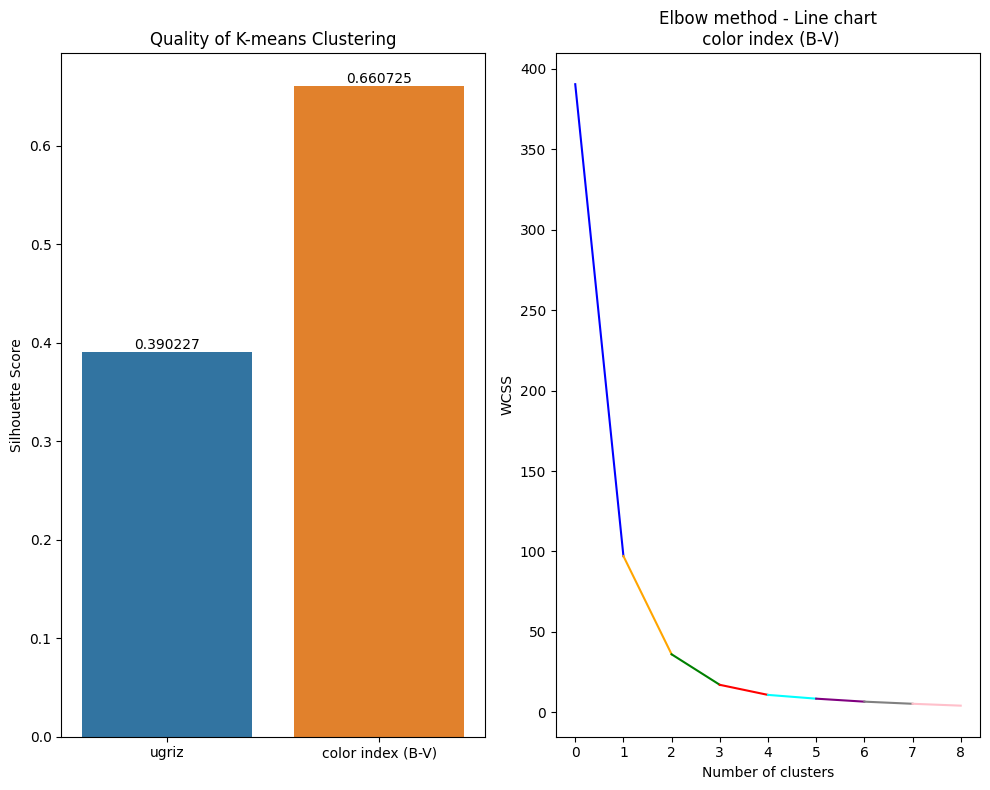

In [17]:
# plot kmeans silhouette score for ugriz and color index and elbow method plot
def plot_kmeans_data(plot_data):
    fig, ax = plt.subplots(1,2,figsize=(10, 8))
    ax = ax.flatten()
    sns.barplot(data=plot_data,x='test_data_type',y='sil_score',hue='test_data_type',ax=ax[0])
    ax[0].set_title('Quality of K-means Clustering')
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Silhouette Score')
    # add silhouette score to bar plot
    for i in ax[0].containers:
        ax[0].bar_label(i,)
    check_nclusters(ax[1])
    fig.tight_layout()

plot_kmeans_data(plot_data)


##### Star Clusters: Interpretation
*Is photometric data from bandpass filters (u,g,r,i,z) sufficient to cluster the different star spectral classes? Does clustering by color index (B-V) give us stronger clustering?*
- Silhouette scores from the testing data, shows that color index (B-V) gives better separation between clustering groups and tighter grouping of points within each cluster. The Elbow method plot shows that selecting 5 for the number of clusters for the K-means was appropriate as the segments change in direction is apparent at 5 clusters. K-means clustering with photometric data shows a promising results, with a silhouette score of 0.33. However, transforming the photometric data via Jordi magnitude equations increases the silhouette score by nearly 70%.

##### Star Clusters: Bias
- The Jordi equations create a faux bandpass filters which do not exist for the sdss data. While the color index was a useful feature, it relies heavily on the background of the individual exploring the dataset.

####  ML Classification
* Do classes and subclasses in the sdss dataset have a unique signatures, comprised of numerical variable combinations?*

##### ML Classification: Background
- K-nearest Neighbors (KNN) works by identifying distance between a new point and existing data in the training set. For example, a point is 1 unit away from two existing points that are *type A* and 10 units away from two existing points that are *type B*. KNN would classify this new point as *type A*
- Support Vector Machines (SVM) works by generating a high dimensional plane such that data points of different classes are separated.
- Random Forest (RF) combines multiple decision trees to make predictions. Utilizing multiple decision trees, causes the complexity of the algorithm to increase. As a result of this increased complexity, RF is susceptible to over training.

##### ML Classification: Analysis Steps
1. Create  subsets of data to train different models
2. Scale (Normalize) subsets to reduce noise in datasets due to outliers
3. Split subset data into subsets for training and testing
4. Train and test models 
5. Evaluate model performance 

In [18]:
# create subsets
df_original_data_class = df.loc[:,['ra','dec','u', 'g', 'r', 'i', 'z','redshift','class']]
df_original_data_subclass = df.loc[:,['ra','dec','u', 'g', 'r', 'i', 'z','redshift','subClass']]
df_calc_data_class = df.loc[:,['ra','dec','u', 'g', 'r', 'i', 'z','redshift','class','dist','B-V']]
df_calc_data_subclass = df.loc[:,['ra','dec','u', 'g', 'r', 'i', 'z','redshift','subClass','dist','B-V']]
df_no_mystery = df[~df['subClass'].isin(['Mystery QSO','Mystery GALAXY'])].loc[:,['ra','dec','u', 'g', 'r', 'i', 'z','redshift','subClass','dist','B-V']]

In [19]:
# create function that will scale and split the test data
def scale_and_split_data(df,predictor_type):
    # predictor type can be class(i.e QSO,STAR,GALAXY) or subclass
    scaler =sklearn.preprocessing.StandardScaler()
    df_scaled = df.drop(predictor_type, axis=1)
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)    
    X = df_scaled
    y = df[predictor_type]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
    return([X_train, X_test, y_train, y_test])

In [20]:
# create dictionaries 

# create dictionary for different sklearn models
ml_methods = {'K-Nearest Neighbors':sklearn.neighbors.KNeighborsClassifier(),
              'Random Forest':sklearn.ensemble.RandomForestClassifier(),
              'Support Vector Machine':sklearn.svm.SVC()}

# create dictionary for different test case data
test_data = {'predict class given original data':scale_and_split_data(df_original_data_class,'class'),
             'predict class given calculated data':scale_and_split_data(df_calc_data_class,'class'),
             'predict subclass given original data':scale_and_split_data(df_original_data_subclass,'subClass'),
             'predict subclass given calculated data':scale_and_split_data(df_calc_data_subclass,'subClass'),
             'predict subclass given calculated data without mystery QSO and GALAXY':scale_and_split_data(df_no_mystery,'subClass')}

# create dictionary to store model results
model_data = {'data_type':[], 'ml_algo':[], 'accuracy':[]}

In [21]:
# generate model results
def evaluate_ml_model_performance(test_data,methods):
    for test_data_type in test_data.keys():
        print(100*'=')
        print(f'Performance for: {test_data_type}')
        print(100*'-')
        for ml_method in methods.keys():
            data = test_data[test_data_type]
            model = methods[ml_method]
            model.fit(data[0], data[2])
            y_pred = model.predict(data[1])
            accuracy = sklearn.metrics.accuracy_score(data[3], y_pred)
            print(f'{ml_method} accuracy: {accuracy:.4f}')
            if 'mystery' in test_data_type:
                model_data['data_type'].append('no Mystery subclass')
                model_data['ml_algo'].append(ml_method)
                model_data['accuracy'].append(accuracy)
            else:
                split_key = test_data_type.split()
                data_type = " ".join([split_key[3],split_key[1]])
                model_data['data_type'].append(data_type)
                model_data['ml_algo'].append(ml_method)
                model_data['accuracy'].append(accuracy)
        print(100*'='+'\n')
    return(model_data)

results = evaluate_ml_model_performance(test_data,ml_methods)

Performance for: predict class given original data
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors accuracy: 0.9487
Random Forest accuracy: 0.9811
Support Vector Machine accuracy: 0.9667

Performance for: predict class given calculated data
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors accuracy: 0.9640
Random Forest accuracy: 0.9856
Support Vector Machine accuracy: 0.9748

Performance for: predict subclass given original data
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors accuracy: 0.7696
Random Forest accuracy: 0.8416
Support Vector Machine accuracy: 0.8236

Performance for: predict subclass given calculated data
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors accuracy: 0.8056
Random Forest accu

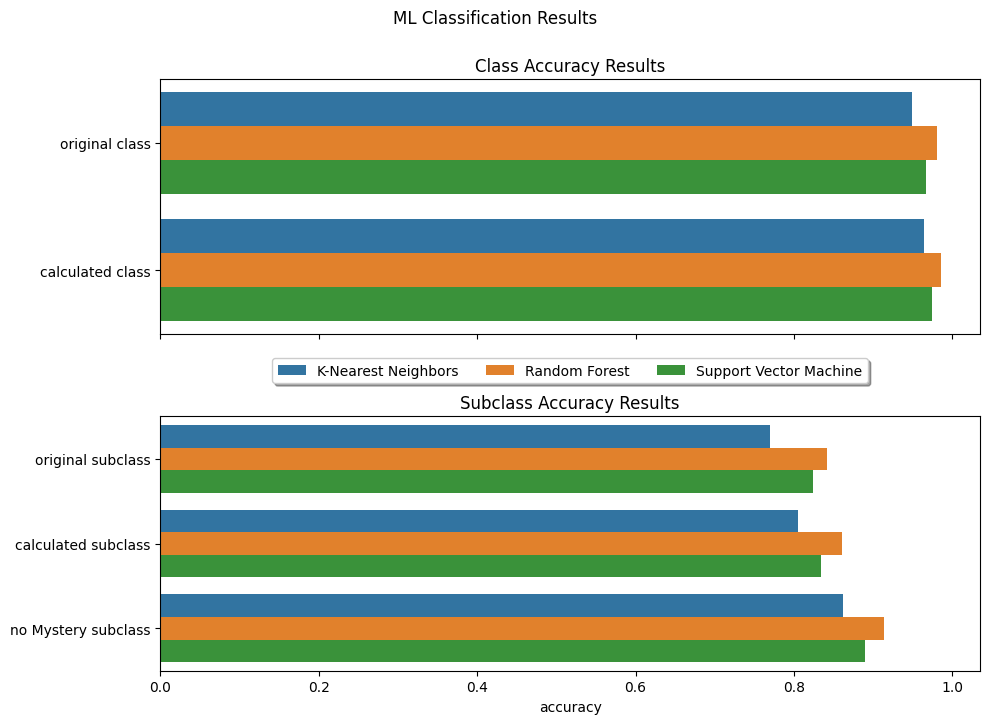

: 

In [ ]:
# visulaize classification model results
df_results = pd.DataFrame.from_dict(results)
fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)
fig.suptitle("ML Classification Results",y=0.9)
ax = ax.flatten()
sns.barplot(data=df_results[df_results['data_type'].isin(['original class','calculated class'])],y='data_type',x='accuracy',hue='ml_algo',ax=ax[0],legend=False)
ax[0].set_ylabel('')
ax[0].set_title('Class Accuracy Results')
sns.barplot(data=df_results[~df_results['data_type'].isin(['original class','calculated class'])],y='data_type',x='accuracy',hue='ml_algo',ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Subclass Accuracy Results')
ax[1].legend(bbox_to_anchor=(0.5, 1.18), fancybox=True, shadow=True,ncol=3,loc='center')
fig.tight_layout(rect=[0,0,1,0.9])

#####  ML Classification: Interpretation
* ML Classification: Do classes and subclasses in the sdss dataset have a unique signatures, comprised of numerical variable combinations?*
* How well do machine learning classification algorithm predict class and subclass categorical variables Is there a difference in model performance when utilizing calculated features versus not(values include in original dataset)? From the model that performs best, can we predict what subclass the Mystery QSO and Mystery Galaxy belong to?*
- Accuracy results for K-Nearest Neighbors (KNN), Random Forest, and Support Vector Machine (SVM) models ranged from ~76.9% to 98.6%. Time and time again the Random Forest model outperformed the SVM model and KNN model. Calculated features, color index (B-V) and distance had the largest impact on the KNN model accuracy. The KNN model accuracy increased 3.6% when incorporating calculated features. According to the model accuracy results classes and subclasses can be classified by leveraging numerical features in this dataset.

#####  ML Classification: Bias
- The calculated variables are just estimates and could artificially inflate model accuracy results. Model selection was influenced by the results in [Janga et al. 2023](https://www.mdpi.com/2072-4292/15/16/4112) and it is possible that better models exist for this application.

#### Final Thoughts
##### Final Thoughts: Summary
- The dataset from the Sloan Digital Sky Survey contained over 5,000 photometric observations of stars, galaxies, and quasars. Classification of these objects is heavily dependent on distance as seen on the Redshift Distance by Class plot. Converting ugriz to UBVRI magnitudes proved to be a powerful feature transformation. This transformation increased our K-means silhouette score to increase by ~70%. Lastly, KNN, SVM, and Random Forest models saw accuracy increases thanks to calculated features.


#### Video

In [ ]:
from IPython.display import Video

#Video("207_final_project.mp4")